In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from functools import reduce
from scipy import stats as stats

In [2]:
listings = pd.read_csv('seattle_airbnb_data.dir/listings.csv')
listings_filtered = pd.read_csv('listings_filtered.csv')

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [5]:
listings_filtered.columns

Index(['id', 'zipcode', 'bedrooms', 'first_review', 'last_review',
       'reviews_per_month', 'avg_price', 'first_review_2015',
       'last_review_2015', 'total_reviews', 'delta_days',
       'reviews_per_month_2015', 'monthly_proxy_revenue_method_1',
       'monthly_proxy_revenue_method_2', 'monthly_profit_low_end',
       'monthly_profit_high_end', 'rent', 'better_airbnb_high_end',
       'better_airbnb_low_end'],
      dtype='object')

In [6]:
listings_filtered['monthly_profit_diff_high_end'] = listings_filtered['monthly_profit_high_end'] - listings_filtered['rent']
listings_filtered

,id,zipcode,bedrooms,first_review,last_review,reviews_per_month,avg_price,first_review_2015,last_review_2015,total_reviews,delta_days,reviews_per_month_2015,monthly_proxy_revenue_method_1,monthly_proxy_revenue_method_2,monthly_profit_low_end,monthly_profit_high_end,rent,better_airbnb_high_end,better_airbnb_low_end,monthly_profit_diff_high_end
0,241032,98119.0,1.0,2011-11-01,2016-01-02,4.07,85.000000,2015-01-03,2015-12-24,68.0,355,5.661972,481.666667,345.950000,578.000000,770.666667,1247.40,False,False,-476.733333
1,953595,98119.0,1.0,2013-08-19,2015-12-29,1.48,170.931271,2015-02-15,2015-12-29,34.0,317,3.123028,476.946626,252.978282,572.335951,763.114602,1247.40,False,False,-484.285398
2,278830,98119.0,3.0,2012-07-10,2015-10-24,0.89,462.739726,2015-01-04,2015-10-24,16.0,293,1.535836,615.345523,411.838356,738.414627,984.552836,1663.20,False,False,-678.647164
3,2493658,98119.0,1.0,2014-04-27,2015-12-20,1.55,167.947531,2015-01-02,2015-12-20,20.0,352,1.619318,275.943481,260.318673,331.132177,441.509570,1247.40,False,False,-805.890430
4,175576,98119.0,1.0,2011-07-21,2015-11-25,3.33,94.803922,2015-04-20,2015-11-25,48.0,219,6.438356,377.952315,315.697059,453.542778,604.723704,1247.40,False,False,-642.676296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,98103.0,2.0,2015-10-01,2015-12-27,1.56,191.651982,2015-10-01,2015-12-27,5.0,87,1.379310,78.841487,298.977093,94.609785,126.146380,1389.15,False,False,-1263.003620
1994,8578490,98103.0,1.0,2015-10-01,2015-10-16,0.63,67.782805,2015-10-01,2015-10-16,2.0,15,2.000000,10.833333,42.703167,13.000000,17.333333,1297.80,False,False,-1280.466667
1995,3383329,98107.0,1.0,2014-07-08,2015-12-29,4.01,102.818815,2015-01-03,2015-12-29,54.0,360,4.416667,463.099153,412.303449,555.718984,740.958645,1297.80,False,False,-556.841355
1996,8101950,98107.0,3.0,2015-09-27,2015-09-27,0.30,359.000000,2015-09-27,2015-09-27,1.0,0,1.000000,31.229167,107.700000,37.475000,49.966667,1738.80,False,False,-1688.833333


In [7]:
cols_tofit = ['id', 'monthly_profit_diff_high_end']

### 1. there're essentially too many columns, let's see if we can pick some for the modeling; let's start with review scores columns

In [8]:
cols = ['id',
        'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']

In [9]:
combine = pd.merge(left = listings_filtered[cols_tofit],
                   right = listings[cols],
                   left_on = 'id',
                   right_on = 'id',
                   how = 'left')
combine

,id,monthly_profit_diff_high_end,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,241032,-476.733333,95.0,10.0,10.0,10.0,10.0,9.0,10.0
1,953595,-484.285398,96.0,10.0,10.0,10.0,10.0,10.0,10.0
2,278830,-678.647164,92.0,9.0,9.0,10.0,10.0,9.0,9.0
3,2493658,-805.890430,97.0,10.0,10.0,10.0,10.0,10.0,9.0
4,175576,-642.676296,97.0,10.0,10.0,10.0,10.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...
1993,262764,-1263.003620,92.0,9.0,8.0,10.0,10.0,10.0,8.0
1994,8578490,-1280.466667,100.0,9.0,8.0,10.0,10.0,10.0,10.0
1995,3383329,-556.841355,96.0,10.0,10.0,10.0,10.0,9.0,10.0
1996,8101950,-1688.833333,80.0,8.0,10.0,4.0,8.0,10.0,8.0


In [10]:
combine.isna().sum()

id                               0
monthly_profit_diff_high_end     3
review_scores_rating            14
review_scores_accuracy          18
review_scores_cleanliness       16
review_scores_checkin           18
review_scores_communication     15
review_scores_location          17
review_scores_value             18
dtype: int64

<AxesSubplot:>

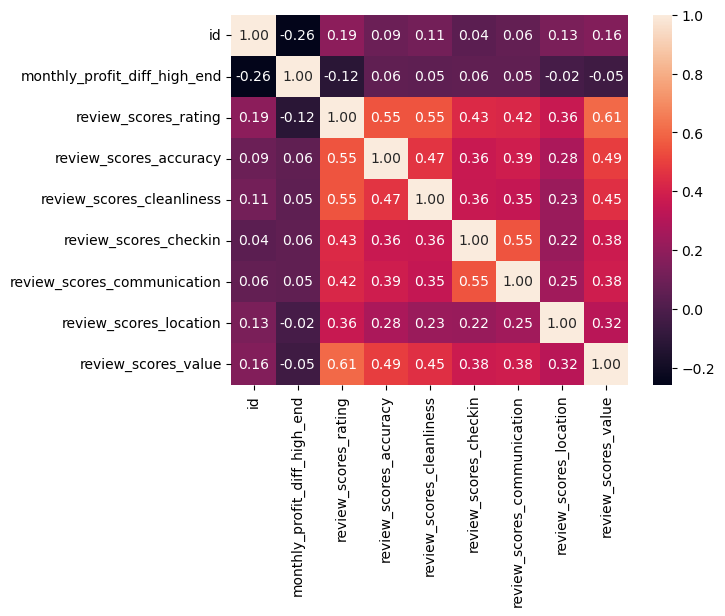

In [11]:
sns.heatmap(combine.corr(method='spearman'), fmt='.2f', annot=True)

In [12]:
combine[['review_scores_value', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness']]

,review_scores_value,review_scores_rating,review_scores_accuracy,review_scores_cleanliness
0,10.0,95.0,10.0,10.0
1,10.0,96.0,10.0,10.0
2,9.0,92.0,9.0,9.0
3,9.0,97.0,10.0,10.0
4,10.0,97.0,10.0,10.0
...,...,...,...,...
1993,8.0,92.0,9.0,8.0
1994,10.0,100.0,9.0,8.0
1995,10.0,96.0,10.0,10.0
1996,8.0,80.0,8.0,10.0


### it has negative relations with rating/value, strange; and seems better off comparing scores in each category; there're also some strong correlation between profit vs id, maybe id means joining date? keep that in mind.

### 2. host related cols

In [13]:
cols = ['id','host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',]

In [14]:
combine = pd.merge(left = listings_filtered[cols_tofit],
                   right = listings[cols],
                   left_on = 'id',
                   right_on = 'id',
                   how = 'left')
combine

,id,monthly_profit_diff_high_end,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified
0,241032,-476.733333,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t
1,953595,-484.285398,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t
2,278830,-678.647164,1452570,https://www.airbnb.com/users/show/1452570,Emily,2011-11-29,"Seattle, Washington, United States","Hi, I live in Seattle, Washington but I'm orig...",within an hour,100%,NaN,f,https://a0.muscache.com/ac/users/1452570/profi...,https://a0.muscache.com/ac/users/1452570/profi...,Queen Anne,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t
3,2493658,-805.890430,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t
4,175576,-642.676296,239585,https://www.airbnb.com/users/show/239585,Ray & Eileen,2010-09-19,"Seattle, Washington, United States",Eileen and Ray were born in Seattle just three...,within a few hours,100%,100%,t,https://a2.muscache.com/ac/users/239585/profil...,https://a2.muscache.com/ac/users/239585/profil...,Queen Anne,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,-1263.003620,1379138,https://www.airbnb.com/users/show/1379138,Rachel,2011-11-07,"Seattle, Washington, United States",We are a professional family with 2 high energ...,within an hour,100%,100%,f,https://a0.muscache.com/ac/users/1379138/profi...,https://a0.muscache.com/ac/users/1379138/profi...,Fremont,1.0,1.0,"['email', 'phone', 'linkedin', 'reviews', 'kba']",t,t
1994,8578490,-1280.466667,11847918,https://www.airbnb.com/users/show/11847918,Ryan,2014-02-01,"Seattle, Washington, United States",NaN,within a few hours,100%,100%,f,https://a1.muscache.com/ac/users/11847918/prof...,https://a1.muscache.com/ac/users/11847918/prof...,Fremont,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t
1995,3383329,-556.841355,3443346,https://www.airbnb.com/users/show/3443346,Jacqueline,2012-09-01,"Seattle, Washington, United States",I’ve been a landlord (and loved it) for fourte...,within an hour,100%,100%,t,https://a0.muscache.com/ac/users/3443346/profi...,https://a0.muscache.com/ac/users/3443346/profi...,Fremont,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t
1996,8101950,-1688.833333,31148752,https://www.airbnb.com/users/show/31148752,Bo,2015-04-13,US,NaN,within a few hours,99%,100%,f,https://a2.muscache.com/ac/users/31148752/prof...,https://a2.muscache.com/ac/users/31148752/prof...,Holly,354.0,354.0,"['email', 'phone', 'linkedin', 'reviews', 'jum...",t,t


In [15]:
combine.isna().sum()

id                                0
monthly_profit_diff_high_end      3
host_id                           0
host_url                          0
host_name                         0
host_since                        0
host_location                     0
host_about                      398
host_response_time              187
host_response_rate              187
host_acceptance_rate            286
host_is_superhost                 0
host_thumbnail_url                0
host_picture_url                  0
host_neighbourhood              121
host_listings_count               0
host_total_listings_count         0
host_verifications                0
host_has_profile_pic              0
host_identity_verified            0
dtype: int64

#### these don't seem useful: host_url, host_name, host_thumbnail_url, host_picture_url;  let's do the host_location and host_neighbourhood later with properties related to the house

In [16]:
combine.drop(columns=['host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_location'], inplace=True)

In [17]:
combine.dtypes

id                                int64
monthly_profit_diff_high_end    float64
host_id                           int64
host_since                       object
host_about                       object
host_response_time               object
host_response_rate               object
host_acceptance_rate             object
host_is_superhost                object
host_listings_count             float64
host_total_listings_count       float64
host_verifications               object
host_has_profile_pic             object
host_identity_verified           object
dtype: object

In [18]:
combine[['host_response_time','host_response_rate','host_acceptance_rate']]

,host_response_time,host_response_rate,host_acceptance_rate
0,within a few hours,96%,100%
1,within an hour,98%,100%
2,within an hour,100%,NaN
3,within an hour,98%,100%
4,within a few hours,100%,100%
...,...,...,...
1993,within an hour,100%,100%
1994,within a few hours,100%,100%
1995,within an hour,100%,100%
1996,within a few hours,99%,100%


In [19]:
def remove_percent_symbol(df, col):
    df[col] = df[col].str.strip('%').astype(float)

In [20]:
remove_percent_symbol(combine, 'host_response_rate')
remove_percent_symbol(combine, 'host_acceptance_rate')

In [21]:
combine['host_response_time'].value_counts()

within an hour        952
within a few hours    531
within a day          313
a few days or more     15
Name: host_response_time, dtype: int64

In [22]:
def unpack_list(df, col, min_diff=0.8):
    ''' 
      unpack the host_verifications column
      for each item in the list, if almost all the host have it, then it may not be useful
      so we only keep the feature with difference in has/not-has < min_diff
    '''
    
    # first unpack the column and figure out how many things in it
    df[col+'_unpacked'] = df[col].apply(lambda x: set(re.sub("[\[\]\']", '', x).split(', ')))
    all_things = reduce(set.union, combine[col+'_unpacked'])
    
    # loop over each thing to each if each host has it or not
    for thing in all_things:
        tmp = df[col].apply(lambda x: 't' if thing in x else 'f')
        count = tmp.value_counts()
        diff = np.abs(count['f']-count['t'])/count.sum()
        print(thing, diff)
        if diff < min_diff:
            df[col+'_has_'+thing] = tmp
    return all_things

In [23]:
all_things = unpack_list(combine, 'host_verifications')

phone 0.984984984984985
amex 0.985985985985986
photographer 0.996996996996997
facebook 0.013013013013013013
sent_id 0.997997997997998
kba 0.022022022022022022
google 0.6086086086086087
manual_online 0.992992992992993
reviews 0.996996996996997
email 0.958958958958959
jumio 0.3133133133133133
linkedin 0.5175175175175175
manual_offline 0.972972972972973


#### sigh, what's kba and jumio :(

In [24]:
combine.drop(columns=['host_verifications', 'host_verifications_unpacked'], inplace=True)

In [25]:
combine['host_days'] = (pd.to_datetime('2016-01-1') - pd.to_datetime(combine['host_since'])).apply(lambda x: x.days)

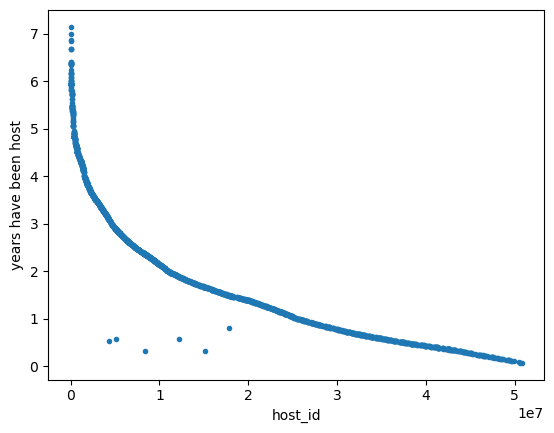

In [26]:
plt.plot(combine.host_id, combine.host_days/365, '.'); plt.xlabel('host_id'); plt.ylabel('years have been host');

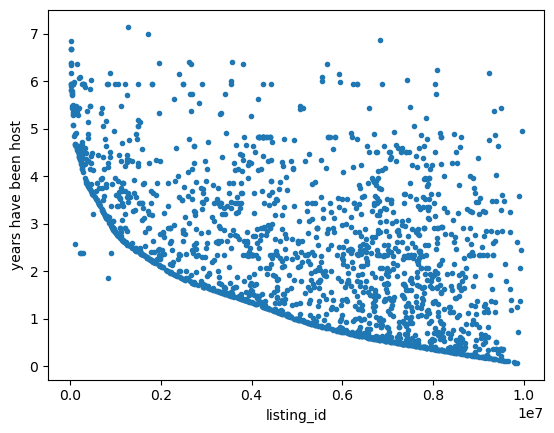

In [27]:
plt.plot(combine.id, combine.host_days/365, '.'); plt.xlabel('listing_id'); plt.ylabel('years have been host');

#### well, i guess this means the number of airbnb hosts starts slow and quickly increases; roughly 80% only been a host for < 2 yrs; plotting against listing_id doesn't mean too much;

In [28]:
combine.drop(columns = ['host_since'], inplace=True)

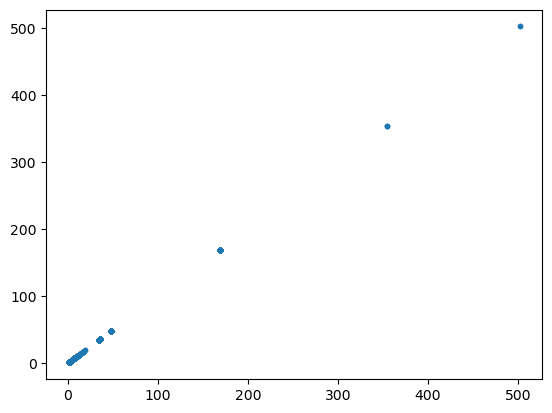

In [29]:
plt.plot(combine.host_listings_count, combine.host_total_listings_count, '.') # these two are the same

In [30]:
combine.drop(columns=['host_total_listings_count'], inplace=True)

In [31]:
combine['host_identity_verified'].value_counts()

t    1648
f     350
Name: host_identity_verified, dtype: int64

In [32]:
combine['has_host_about'] = np.where(~combine['host_about'].isna(), 't', 'f')
combine.drop(columns=['host_about'], inplace=True)

In [33]:
combine

,id,monthly_profit_diff_high_end,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,host_verifications_has_facebook,host_verifications_has_kba,host_verifications_has_google,host_verifications_has_jumio,host_verifications_has_linkedin,host_days,has_host_about
0,241032,-476.733333,956883,within a few hours,96.0,100.0,f,3.0,t,t,f,t,f,f,f,1604,t
1,953595,-484.285398,5177328,within an hour,98.0,100.0,t,6.0,t,t,t,f,f,t,t,1044,t
2,278830,-678.647164,1452570,within an hour,100.0,NaN,f,2.0,t,t,t,t,f,f,f,1494,t
3,2493658,-805.890430,5177328,within an hour,98.0,100.0,t,6.0,t,t,t,f,f,t,t,1044,t
4,175576,-642.676296,239585,within a few hours,100.0,100.0,t,1.0,t,t,f,t,f,f,f,1930,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,-1263.003620,1379138,within an hour,100.0,100.0,f,1.0,t,t,f,t,f,f,t,1516,t
1994,8578490,-1280.466667,11847918,within a few hours,100.0,100.0,f,1.0,t,t,f,t,f,f,f,699,f
1995,3383329,-556.841355,3443346,within an hour,100.0,100.0,t,3.0,t,t,t,t,f,f,f,1217,t
1996,8101950,-1688.833333,31148752,within a few hours,99.0,100.0,f,354.0,t,t,f,f,f,t,t,263,f


In [34]:
combine.dtypes

id                                   int64
monthly_profit_diff_high_end       float64
host_id                              int64
host_response_time                  object
host_response_rate                 float64
host_acceptance_rate               float64
host_is_superhost                   object
host_listings_count                float64
host_has_profile_pic                object
host_identity_verified              object
host_verifications_has_facebook     object
host_verifications_has_kba          object
host_verifications_has_google       object
host_verifications_has_jumio        object
host_verifications_has_linkedin     object
host_days                            int64
has_host_about                      object
dtype: object

In [35]:
combine.host_acceptance_rate.value_counts() # this is actually found by the corr heatmap

100.0    1712
Name: host_acceptance_rate, dtype: int64

In [36]:
combine.drop(columns=['host_acceptance_rate'], inplace=True)

In [37]:
cols_num = ['id', 'host_id', 'monthly_profit_diff_high_end', 'host_response_rate', 'host_listings_count', 'host_days']
cols_cat = [col for col in list(combine.columns) if col not in cols_num]

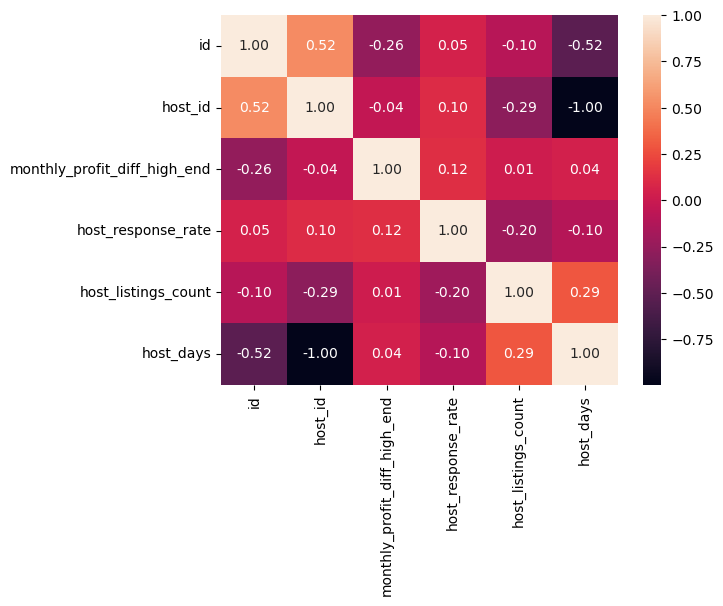

In [38]:
sns.heatmap(combine[cols_num].corr(method='spearman'), fmt='.2f', annot=True);

### as suggested above, host_id and host_days behave almost the same in terms of corr with profit; but the correlation again id remains the strongest, not the id or host_days; host_response_rate is the feature that pops up

In [39]:
cols_cat

['host_response_time',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_verifications_has_facebook',
 'host_verifications_has_kba',
 'host_verifications_has_google',
 'host_verifications_has_jumio',
 'host_verifications_has_linkedin',
 'has_host_about']

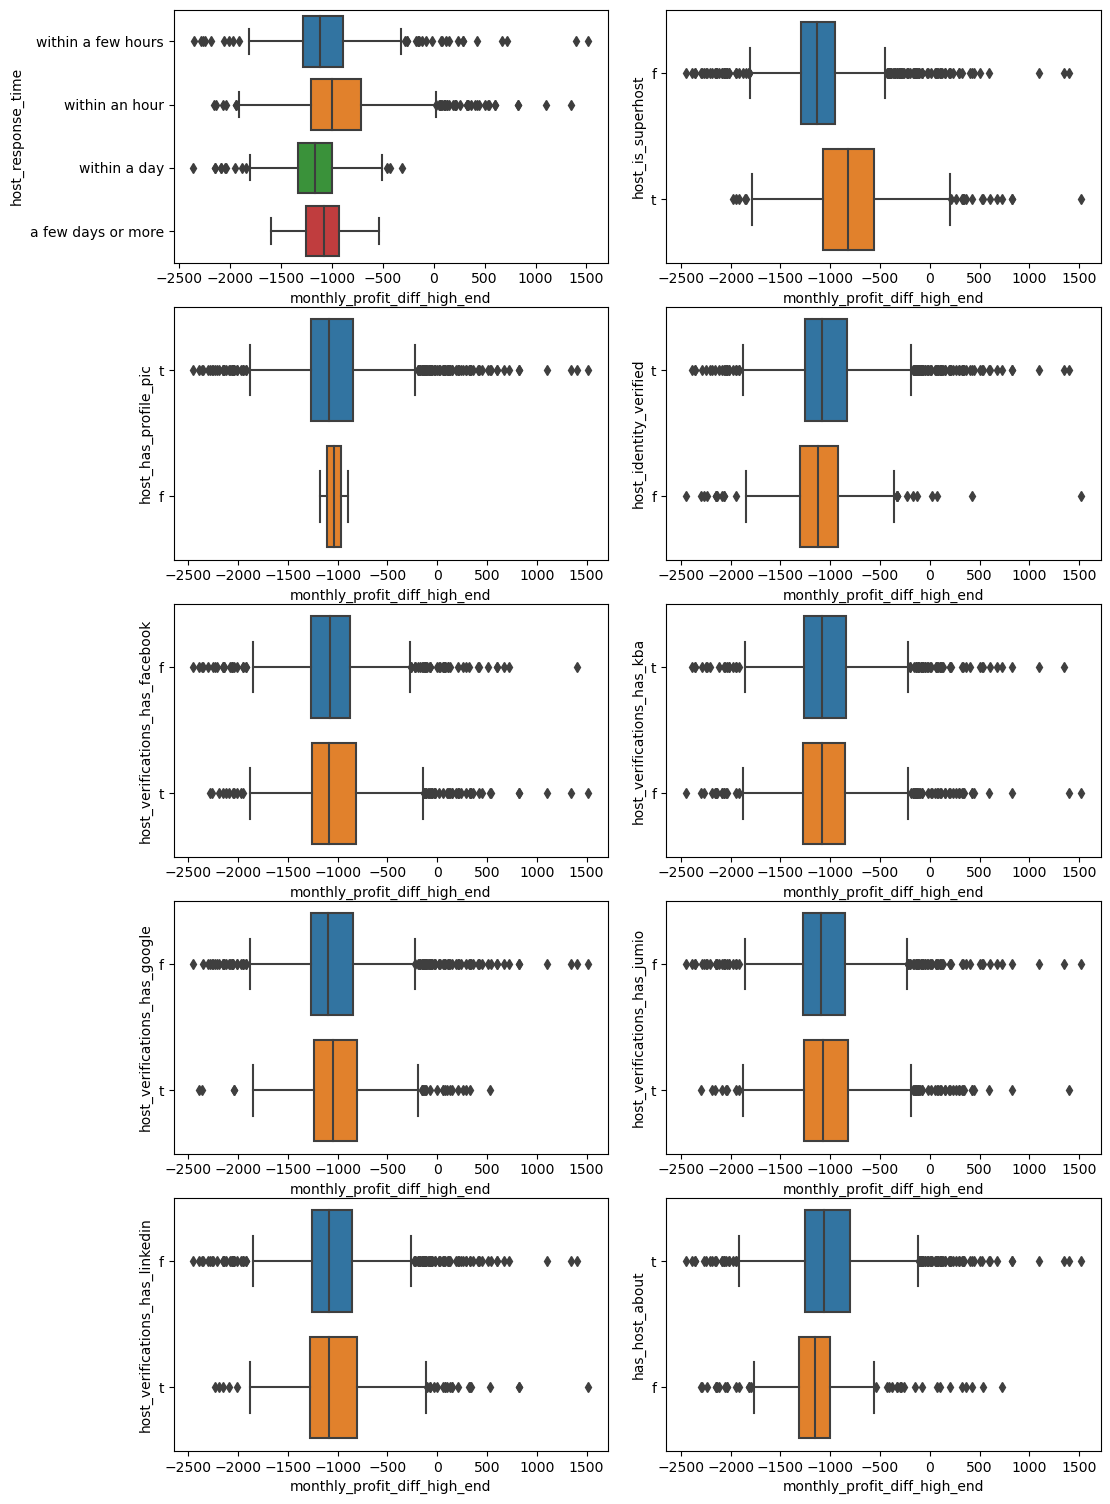

In [40]:
fig, ax = plt.subplots(5,2,figsize=(10,15))
fig.tight_layout()
ax = ax.flatten()
for i, col in enumerate(cols_cat):
    sns.boxplot(data = combine,
                x = 'monthly_profit_diff_high_end',
                y = col,
                ax = ax[i])

### so being a superhost is important; response time is important and has a host_about is somewhat important; the way to verify is not at all

### 3. let's dig deeper into this id feature

In [41]:
cols = ['id', 'first_review', 'number_of_reviews']
combine = pd.merge(left = listings_filtered[cols_tofit],
                   right = listings[cols],
                   left_on = 'id',
                   right_on = 'id',
                   how = 'left')
combine

,id,monthly_profit_diff_high_end,first_review,number_of_reviews
0,241032,-476.733333,2011-11-01,207
1,953595,-484.285398,2013-08-19,43
2,278830,-678.647164,2012-07-10,38
3,2493658,-805.890430,2014-04-27,32
4,175576,-642.676296,2011-07-21,181
...,...,...,...,...
1993,262764,-1263.003620,2015-10-01,5
1994,8578490,-1280.466667,2015-10-01,2
1995,3383329,-556.841355,2014-07-08,73
1996,8101950,-1688.833333,2015-09-27,1


In [42]:
combine['first_review_days'] = (pd.to_datetime('2016-01-01') - pd.to_datetime(combine['first_review'])).apply(lambda x: x.days)
combine.drop(columns=['first_review'])

,id,monthly_profit_diff_high_end,number_of_reviews,first_review_days
0,241032,-476.733333,207,1522
1,953595,-484.285398,43,865
2,278830,-678.647164,38,1270
3,2493658,-805.890430,32,614
4,175576,-642.676296,181,1625
...,...,...,...,...
1993,262764,-1263.003620,5,92
1994,8578490,-1280.466667,2,92
1995,3383329,-556.841355,73,542
1996,8101950,-1688.833333,1,96


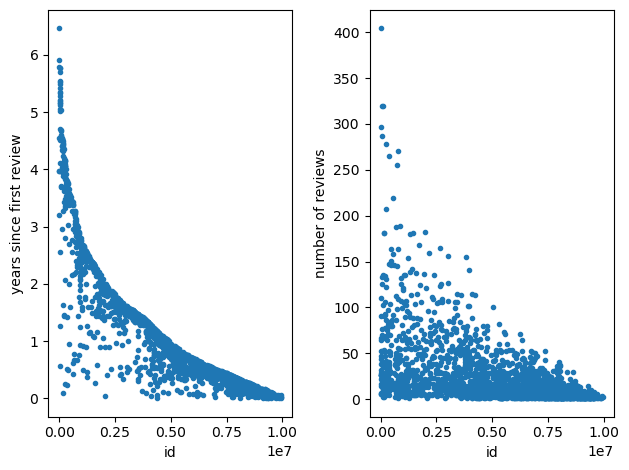

In [43]:
plt.subplot(1,2,1);
plt.plot(combine.id, combine.first_review_days/365, '.');
plt.xlabel('id'); plt.ylabel('years since first review');
plt.subplot(1,2,2);
plt.plot(combine.id, combine.number_of_reviews, '.')
plt.xlabel('id'); plt.ylabel('number of reviews');
plt.tight_layout()

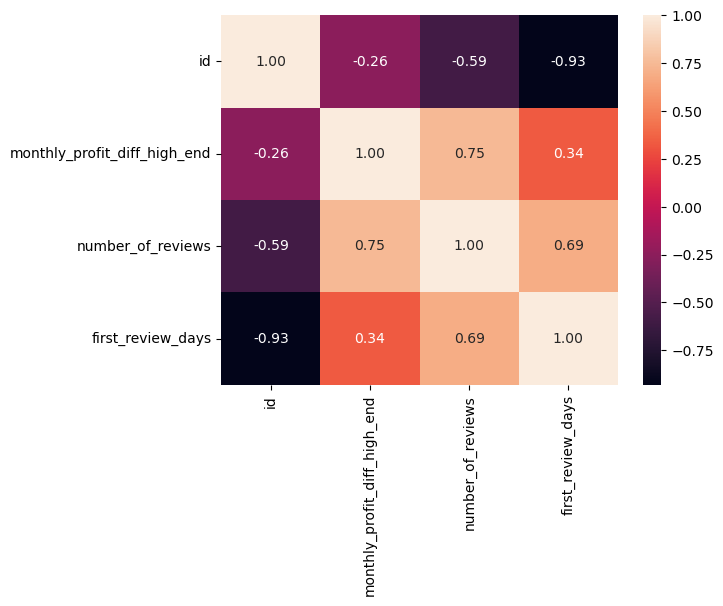

In [44]:
sns.heatmap(combine.corr(method='spearman'), annot=True, fmt='.2f');

### this explains it; id strongly correlates with first_review_days, weakly corresponding to number_of_reviews; the high correlations between profit_diff and reviews is as expected, since that's how we estimate the profit. We can add first_review_days as a feature

### 4 About bookings

In [45]:
cols = ['id', 'security_deposit', 'cleaning_fee', 'extra_people', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'price']

In [46]:
cols_tmp = cols_tofit + ['avg_price']

In [47]:
combine = pd.merge(left = listings_filtered[cols_tmp],
                   right = listings[cols],
                   left_on = 'id',
                   right_on = 'id',
                   how = 'left')
combine

,id,monthly_profit_diff_high_end,avg_price,security_deposit,cleaning_fee,extra_people,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
0,241032,-476.733333,85.000000,NaN,NaN,$5.00,f,moderate,f,f,$85.00
1,953595,-484.285398,170.931271,$100.00,$40.00,$0.00,f,strict,t,t,$150.00
2,278830,-678.647164,462.739726,$700.00,$125.00,$15.00,f,strict,f,f,$450.00
3,2493658,-805.890430,167.947531,$100.00,$40.00,$0.00,f,strict,t,t,$150.00
4,175576,-642.676296,94.803922,NaN,$15.00,$15.00,f,moderate,t,f,$95.00
...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,-1263.003620,191.651982,$150.00,$85.00,$50.00,f,strict,f,f,$154.00
1994,8578490,-1280.466667,67.782805,NaN,$20.00,$0.00,f,moderate,f,f,$65.00
1995,3383329,-556.841355,102.818815,$500.00,NaN,$8.00,t,moderate,t,t,$95.00
1996,8101950,-1688.833333,359.000000,NaN,$230.00,$0.00,f,strict,f,f,$359.00


In [48]:
def remove_dollar(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: float(x.lstrip('$').replace(r',','')) if isinstance(x, str) else np.nan)

In [49]:
remove_dollar(combine, ['cleaning_fee','extra_people', 'price', 'security_deposit'])
combine

,id,monthly_profit_diff_high_end,avg_price,security_deposit,cleaning_fee,extra_people,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
0,241032,-476.733333,85.000000,NaN,NaN,5.0,f,moderate,f,f,85.0
1,953595,-484.285398,170.931271,100.0,40.0,0.0,f,strict,t,t,150.0
2,278830,-678.647164,462.739726,700.0,125.0,15.0,f,strict,f,f,450.0
3,2493658,-805.890430,167.947531,100.0,40.0,0.0,f,strict,t,t,150.0
4,175576,-642.676296,94.803922,NaN,15.0,15.0,f,moderate,t,f,95.0
...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,-1263.003620,191.651982,150.0,85.0,50.0,f,strict,f,f,154.0
1994,8578490,-1280.466667,67.782805,NaN,20.0,0.0,f,moderate,f,f,65.0
1995,3383329,-556.841355,102.818815,500.0,NaN,8.0,t,moderate,t,t,95.0
1996,8101950,-1688.833333,359.000000,NaN,230.0,0.0,f,strict,f,f,359.0


In [50]:
combine['extra_people_ratio'] = combine['extra_people'] / combine['price']

In [51]:
cols_cat = ['cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'instant_bookable']
cols_num = ['security_deposit', 'cleaning_fee', 'extra_people','monthly_profit_diff_high_end', 'avg_price', 'price', 'extra_people_ratio']

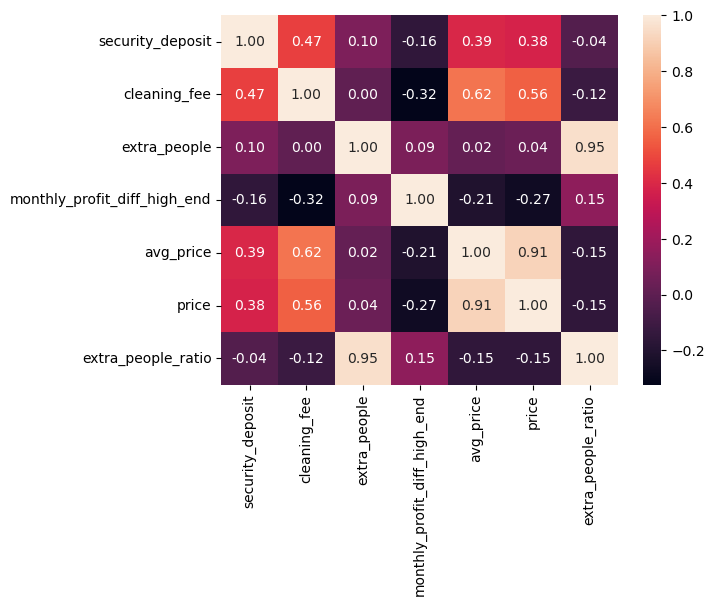

In [52]:
sns.heatmap(combine[cols_num].corr(method='spearman'), fmt='.2f', annot=True);

#### well, the important thing is the negative correlation between profit and price, suggesting some discount is useful; it's unclear whether the cleaning fee is charge to the host or the guest; if it's charged to the host, then the host will increase the price, which in turn reduce the profit; if it's charged to the guest, then guest is less likely to make the booking with higher cleaning fee; same for security deposit; let's drop thses two for now; somewhat surprised to see increasing the fee for extra people actually increase the profit, does that mean when host charge more for extra people, it reduce the price?

In [53]:
cols_cat

['cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'instant_bookable']

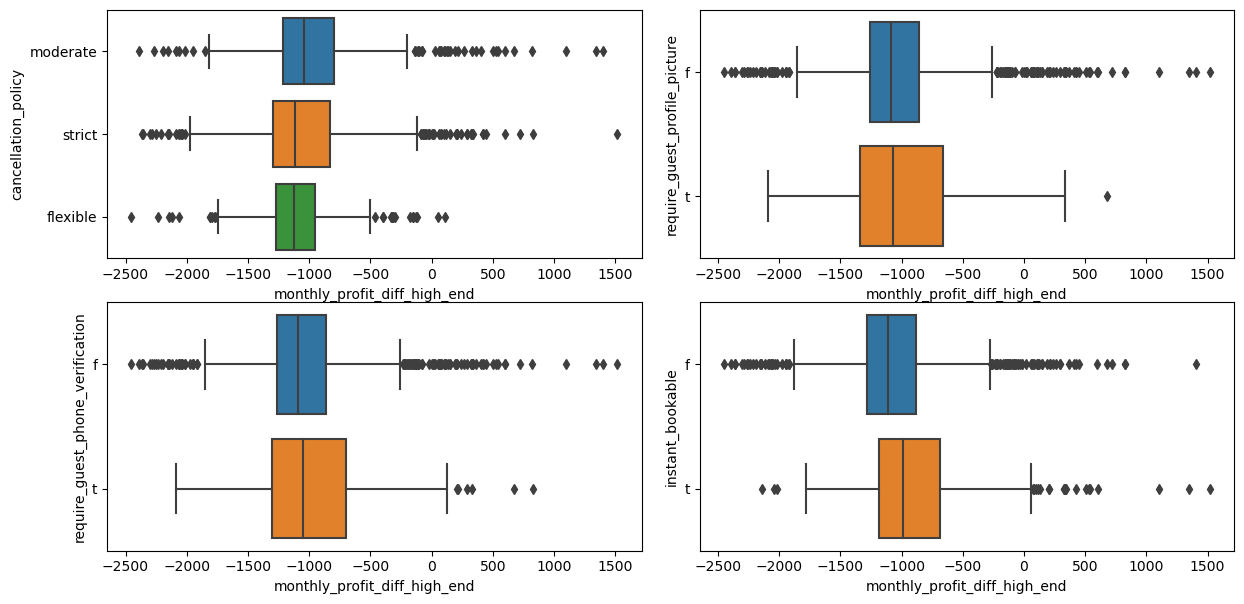

In [54]:
fig, ax = plt.subplots(2,2,figsize=(12,6))
fig.tight_layout()
ax = ax.flatten()
for i, col in enumerate(cols_cat):
    sns.boxplot(data = combine,
                x = 'monthly_profit_diff_high_end',
                y = col,
                ax = ax[i])

### cancellation policy and instant bookable seem to have some impacts

### 5. The amenities

In [55]:
cols = ['id', 'amenities']
combine = pd.merge(left = listings_filtered[cols_tofit],
                   right = listings[cols],
                   left_on = 'id',
                   right_on = 'id',
                   how = 'left')
combine

,id,monthly_profit_diff_high_end,amenities
0,241032,-476.733333,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,953595,-484.285398,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,278830,-678.647164,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
3,2493658,-805.890430,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
4,175576,-642.676296,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
...,...,...,...
1993,262764,-1263.003620,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
1994,8578490,-1280.466667,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1995,3383329,-556.841355,"{Internet,""Wireless Internet"",Kitchen,""Free Pa..."
1996,8101950,-1688.833333,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."


In [56]:
def unpack_list2(df, col, min_diff=0.9):
    ''' 
      similar to unpack_list, but deals with {} in the amentities
    '''
    
    # first unpack the column and figure out how many things in it
    df[col+'_unpacked'] = df[col].apply(lambda x: set(re.sub('[\{\}\"]', '', x).split(',')))
    all_things = reduce(set.union, combine[col+'_unpacked'])
    
    # loop over each thing to each if each host has it or not
    for thing in all_things:
        tmp = df[col].apply(lambda x: 't' if thing in x else 'f')
        count = tmp.value_counts()
        if 'f' not in count:  # this is possible
            continue
        diff = np.abs(count['f']-count['t'])/count.sum()
        print(thing, diff)
        if diff < min_diff:
            df[thing] = tmp
    return all_things

In [57]:
all_things = unpack_list2(combine, 'amenities', min_diff=1.0)

Wireless Internet 0.9429429429429429
Safety Card 0.5825825825825826
Hair Dryer 0.5415415415415415
Washer / Dryer 0.998998998998999
Heating 0.938938938938939
Family/Kid Friendly 0.22922922922922923
Dryer 0.6796796796796797
Iron 0.5395395395395396
Hot Tub 0.8288288288288288
Doorman 0.943943943943944
Kitchen 0.9109109109109109
Other pet(s) 0.975975975975976
Air Conditioning 0.5995995995995996
Laptop Friendly Workspace 0.5805805805805806
Indoor Fireplace 0.5985985985985987
Pets live on this property 0.6536536536536537
Elevator in Building 0.4824824824824825
Buzzer/Wireless Intercom 0.6586586586586587
Free Parking on Premises 0.14414414414414414
Pool 0.8868868868868869
Smoking Allowed 0.978978978978979
Lock on Bedroom Door 0.997997997997998
Wheelchair Accessible 0.7917917917917918
Cat(s) 0.8618618618618619
Washer 0.6106106106106106
Dog(s) 0.7827827827827828
Hangers 0.5165165165165165
Pets Allowed 0.7087087087087087
Smoke Detector 0.7827827827827828
Shampoo 0.4824824824824825
Gym 0.715715715

#### out of curiosity, is mentioning pet in the review important? this likely means the hosts have pet

In [58]:
reviews = pd.read_csv('seattle_airbnb_data.dir/reviews.csv')
pat = re.compile(r'(\W|^)(cat|kitten|dog|puppy)(\W|$)')
reviews['has_pet'] = reviews.comments.apply(lambda x: True if (isinstance(x,str) and pat.search(x.lower())) else False)
tmp = reviews.groupby('listing_id').agg({'has_pet':any})
combine = pd.merge(left=combine, right=tmp, left_on='id', right_on='listing_id', how='left')
combine['has_pet'] = np.where(combine['has_pet'], 't', 'f')

In [59]:
combine.head()

,id,monthly_profit_diff_high_end,amenities,amenities_unpacked,Wireless Internet,Safety Card,Hair Dryer,Washer / Dryer,Heating,Family/Kid Friendly,Dryer,Iron,Hot Tub,Doorman,Kitchen,Other pet(s),Air Conditioning,Laptop Friendly Workspace,Indoor Fireplace,Pets live on this property,Elevator in Building,Buzzer/Wireless Intercom,Free Parking on Premises,Pool,Smoking Allowed,Lock on Bedroom Door,Wheelchair Accessible,Cat(s),Washer,Dog(s),Hangers,Pets Allowed,Smoke Detector,Shampoo,Gym,Fire Extinguisher,Cable TV,24-Hour Check-in,Essentials,First Aid Kit,Internet,TV,Carbon Monoxide Detector,Breakfast,Suitable for Events,has_pet
0,241032,-476.733333,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...","{Kitchen, Air Conditioning, Wireless Internet,...",t,f,f,f,t,t,t,f,f,f,t,f,t,f,f,f,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,f,t,f,f,f,t,t,f,f,f,t
1,953595,-484.285398,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...","{Kitchen, Essentials, Wireless Internet, Smoke...",t,t,f,f,t,t,t,f,f,f,t,f,f,f,f,f,f,t,t,f,f,f,f,f,t,f,f,f,t,f,f,t,f,f,t,t,t,t,t,f,f,f
2,278830,-678.647164,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...","{Kitchen, Essentials, Wireless Internet, Smoke...",t,f,f,f,t,t,f,f,f,f,t,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,t,f,t,t,f,t,t,t,t,t,f,f,f
3,2493658,-805.890430,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...","{Kitchen, Essentials, Wireless Internet, Smoke...",t,t,f,f,t,t,t,f,f,f,t,f,f,f,f,f,f,t,t,f,f,f,f,f,t,f,f,f,t,f,f,t,f,f,t,t,t,t,t,f,f,f
4,175576,-642.676296,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...","{Wireless Internet, Safety Card, Hair Dryer, H...",t,t,t,f,t,f,t,t,f,f,t,f,f,t,f,f,f,f,t,f,f,f,f,f,t,f,t,f,t,t,f,t,t,t,t,t,t,t,t,f,f,t


In [60]:
cols_cat = list(combine.columns)[4:] 
len(cols_cat)

42

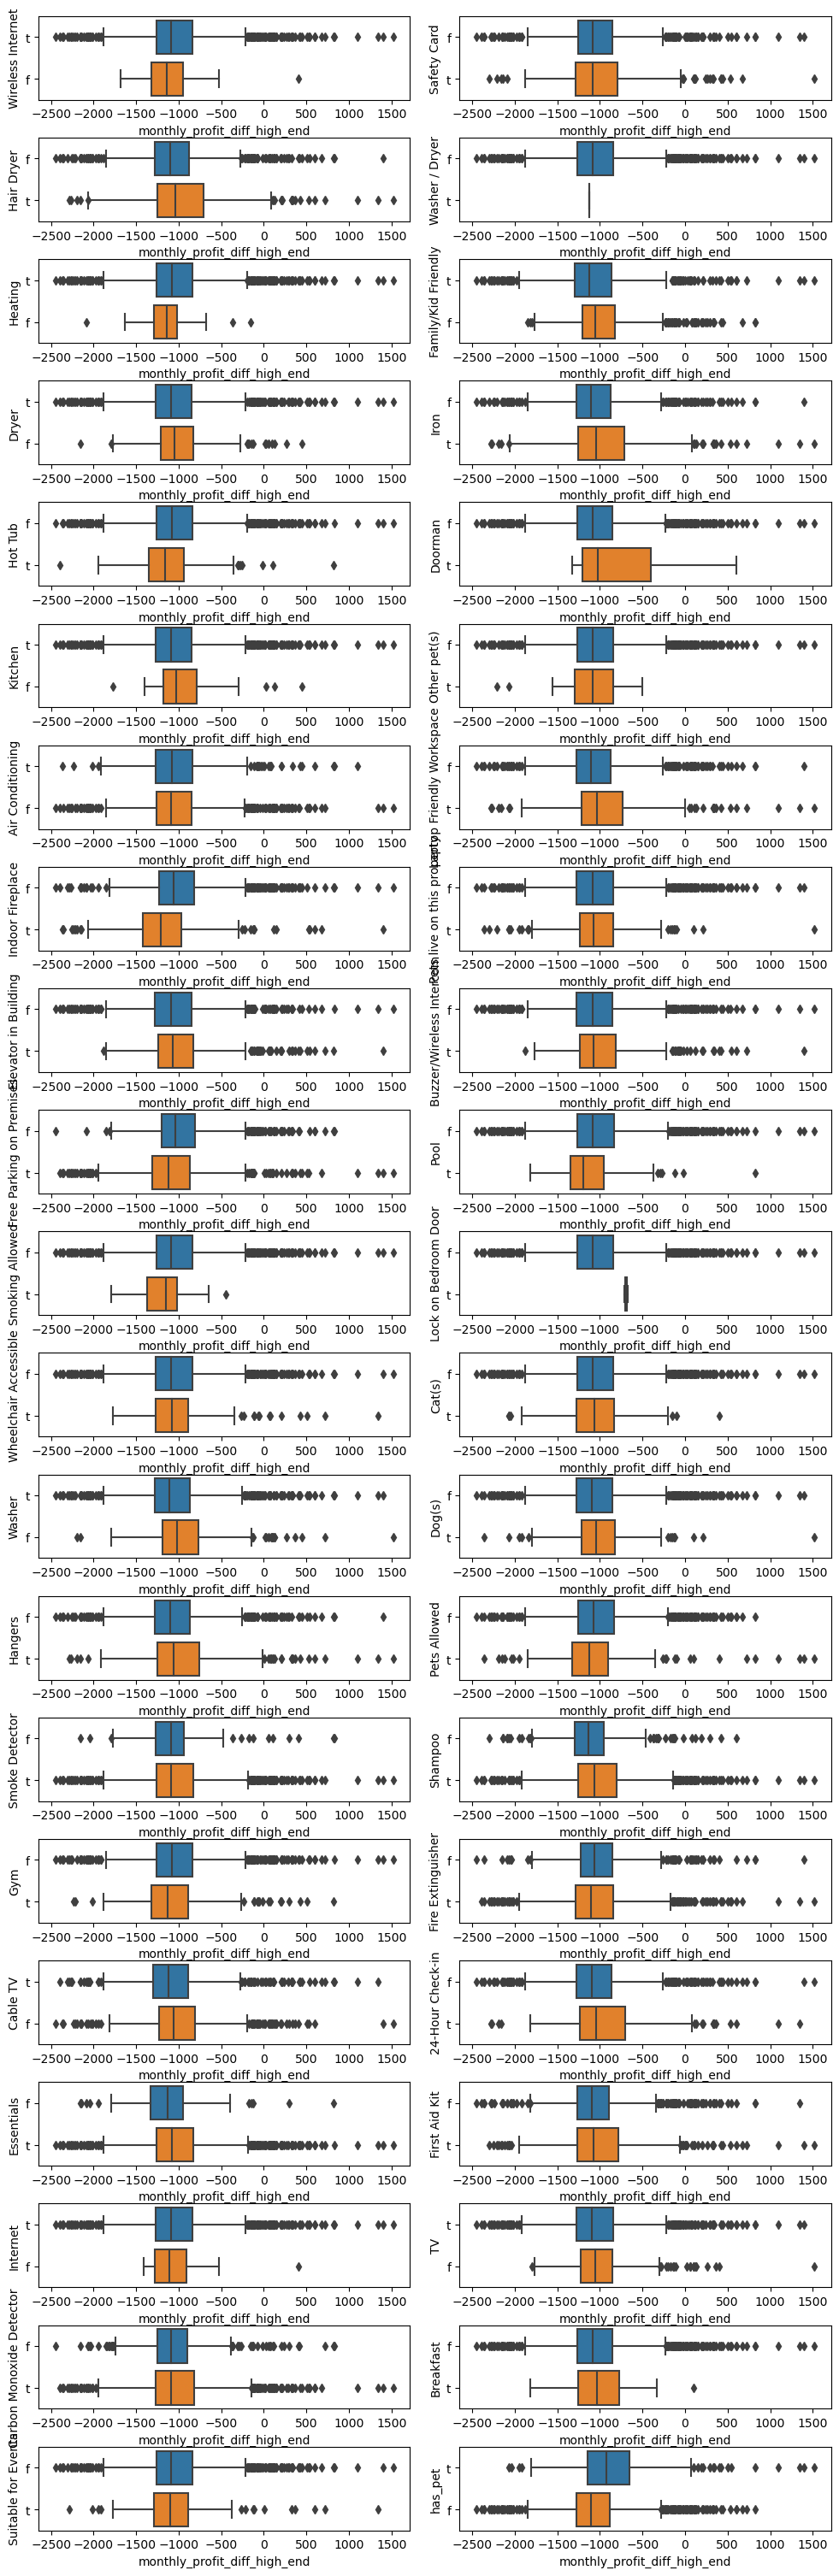

In [61]:
fig, ax = plt.subplots(21,2,figsize=(10,30))
fig.tight_layout()
ax = ax.flatten()
for i, col in enumerate(cols_cat):
    sns.boxplot(data = combine,
                x = 'monthly_profit_diff_high_end',
                y = col,
                ax = ax[i])

#### maybe some t-test ranking would be helpful

In [62]:
def ttest(dat1, dat2, min_count):
    if len(dat1) < min_count or len(dat2) < min_count:
        return np.nan
    else:
        return stats.ttest_ind(dat1, dat2)[1]

In [63]:
combine = combine.dropna(axis=0)

In [64]:
outputs = {}
for col in cols_cat:
    dat1 = combine.loc[combine[col]=='t', 'monthly_profit_diff_high_end'].values
    dat2 = combine.loc[combine[col]=='f', 'monthly_profit_diff_high_end'].values
    p = ttest(dat1, dat2, min_count=10)
    outputs[col] = (p, dat1.mean(), dat2.mean(), len(dat1), len(dat2))
outputs = pd.DataFrame(data=outputs.values(), index=outputs.keys(), columns=['p_value','t_mean','f_mean','t_count','f_count'])

In [65]:
outputs['diff'] = outputs['t_mean'] - outputs['f_mean']
outputs['good_to_have'] = outputs['t_mean'] > outputs['f_mean']

In [66]:
outputs.sort_values(by='p_value')

,p_value,t_mean,f_mean,t_count,f_count,diff,good_to_have
has_pet,2.376902e-14,-854.688900,-1060.836719,285,1710,206.147818,True
Indoor Fireplace,3.361812e-14,-1174.824808,-995.527586,399,1596,-179.297222,False
Free Parking on Premises,8.863033e-12,-1087.351732,-956.767428,1140,855,-130.584303,False
Hair Dryer,6.521640e-09,-930.555607,-1061.433089,458,1537,130.877482,True
Laptop Friendly Workspace,8.950738e-08,-932.963722,-1057.554141,419,1576,124.590420,True
Iron,1.578609e-07,-940.467462,-1058.633285,460,1535,118.165823,True
Shampoo,1.786737e-07,-1002.154403,-1115.395358,1480,515,113.240955,True
Family/Kid Friendly,3.609817e-07,-1069.650234,-970.384836,1226,769,-99.265398,False
Hangers,1.472640e-06,-950.474632,-1057.234047,483,1512,106.759414,True
24-Hour Check-in,3.491537e-06,-937.458227,-1052.068602,360,1635,114.610375,True


In [67]:
outputs[outputs.p_value<0.05].sort_values(by='diff')

,p_value,t_mean,f_mean,t_count,f_count,diff,good_to_have
Indoor Fireplace,3.361812e-14,-1174.824808,-995.527586,399,1596,-179.297222,False
Free Parking on Premises,8.863033e-12,-1087.351732,-956.767428,1140,855,-130.584303,False
Hot Tub,1.923048e-03,-1127.769876,-1022.351139,171,1824,-105.418737,False
Washer,1.271903e-05,-1051.768225,-946.973166,1607,388,-104.795059,False
Family/Kid Friendly,3.609817e-07,-1069.650234,-970.384836,1226,769,-99.265398,False
Pool,3.788839e-02,-1112.047754,-1026.543958,113,1882,-85.503796,False
Cable TV,1.423911e-03,-1064.288470,-1003.399442,917,1078,-60.889027,False
Fire Extinguisher,1.875275e-02,-1050.038689,-1004.549619,1177,818,-45.489070,False
Elevator in Building,6.742597e-05,-967.330622,-1053.793771,517,1478,86.463150,True
Buzzer/Wireless Intercom,3.820838e-04,-956.985451,-1046.726171,341,1654,89.740720,True


#### this is interesting, having small things like hair dryer, iron shampoo actually bring >100 in profit every month, with the most important thing being having a pet!! Why is a doorman important? The first few items also suggest reducing "unnecessary" things in the property seems important, we don't want fireplace, hot tub, washer, pool; Why people don't want parking is strange, maybe this is in countryside neighborhood where profit is low

### 6 property itself

In [68]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [69]:
cols = ['id', 'transit', 'host_location', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'bed_type', 'zipcode', 'property_type', 'host_neighbourhood', 'bedrooms']

In [70]:
combine = pd.merge(left = listings_filtered[cols_tofit+['rent','monthly_profit_high_end']],
                   right = listings[cols],
                   left_on = 'id',
                   right_on = 'id',
                   how = 'left')
combine.head()

,id,monthly_profit_diff_high_end,rent,monthly_profit_high_end,transit,host_location,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,bed_type,zipcode,property_type,host_neighbourhood,bedrooms
0,241032,-476.733333,1247.4,770.666667,NaN,"Seattle, Washington, United States",Queen Anne,West Queen Anne,Queen Anne,Real Bed,98119,Apartment,Queen Anne,1.0
1,953595,-484.285398,1247.4,763.114602,"Convenient bus stops are just down the block, ...","Seattle, Washington, United States",Queen Anne,West Queen Anne,Queen Anne,Real Bed,98119,Apartment,Queen Anne,1.0
2,278830,-678.647164,1663.2,984.552836,The nearest public transit bus (D Line) is 2 b...,"Seattle, Washington, United States",Queen Anne,West Queen Anne,Queen Anne,Real Bed,98119,House,Queen Anne,3.0
3,2493658,-805.890430,1247.4,441.509570,"Convenient bus stops are just down the block, ...","Seattle, Washington, United States",Queen Anne,West Queen Anne,Queen Anne,Real Bed,98119,Apartment,Queen Anne,1.0
4,175576,-642.676296,1247.4,604.723704,The bus stop is just two blocks from our house...,"Seattle, Washington, United States",Queen Anne,West Queen Anne,Queen Anne,Real Bed,98119,House,Queen Anne,1.0


In [71]:
combine['host_location'].value_counts()

Seattle, Washington, United States                    1683
US                                                     102
Spokane, Washington, United States                      36
Kent, Washington, United States                         32
Mercer Island, Washington, United States                10
                                                      ... 
Phoenix, Arizona, United States                          1
United States                                            1
Edmonds, Washington, United States                       1
We live in the house upstairs from the rental flat       1
Arlington, Massachusetts, United States                  1
Name: host_location, Length: 87, dtype: int64

In [72]:
combine['host_neighbourhood'].value_counts()

Belltown               203
Capitol Hill           200
Queen Anne             120
Ballard                107
Minor                   99
                      ... 
South Beacon Hill        1
Industrial District      1
Interbay                 1
Long Beach               1
Central San Pedro        1
Name: host_neighbourhood, Length: 91, dtype: int64

In [73]:
combine['host_in_neighbourhood'] = \
((combine['host_neighbourhood'] == combine['neighbourhood']) | 
(combine['host_neighbourhood'] == combine['neighbourhood_cleansed']) |
(combine['host_neighbourhood'] == combine['neighbourhood_group_cleansed']))

In [74]:
combine['host_in_neighbourhood'] = np.where(combine['host_in_neighbourhood'], 't', 'f')
combine['host_in_neighbourhood'].value_counts()

t    1649
f     349
Name: host_in_neighbourhood, dtype: int64

In [75]:
combine.drop(columns=['host_location', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed'], inplace=True)

In [76]:
combine

,id,monthly_profit_diff_high_end,rent,monthly_profit_high_end,transit,bed_type,zipcode,property_type,bedrooms,host_in_neighbourhood
0,241032,-476.733333,1247.40,770.666667,NaN,Real Bed,98119,Apartment,1.0,t
1,953595,-484.285398,1247.40,763.114602,"Convenient bus stops are just down the block, ...",Real Bed,98119,Apartment,1.0,t
2,278830,-678.647164,1663.20,984.552836,The nearest public transit bus (D Line) is 2 b...,Real Bed,98119,House,3.0,t
3,2493658,-805.890430,1247.40,441.509570,"Convenient bus stops are just down the block, ...",Real Bed,98119,Apartment,1.0,t
4,175576,-642.676296,1247.40,604.723704,The bus stop is just two blocks from our house...,Real Bed,98119,House,1.0,t
...,...,...,...,...,...,...,...,...,...,...
1993,262764,-1263.003620,1389.15,126.146380,We're centrally located to several bus stops t...,Real Bed,98103,House,2.0,t
1994,8578490,-1280.466667,1297.80,17.333333,How to Get to: UW/Husky Stadium): 10 minute d...,Real Bed,98103,Apartment,1.0,t
1995,3383329,-556.841355,1297.80,740.958645,The apartment is easily accessed from I-5 Nort...,Real Bed,98107,Apartment,1.0,t
1996,8101950,-1688.833333,1738.80,49.966667,NaN,Real Bed,98107,House,3.0,f


In [77]:
pat = re.compile('(\W|^)bus(\W|$)')
combine['transit_type'] = combine['transit'].apply(lambda x: 'bus' if isinstance(x, str) and pat.search(x.lower()) else 'other')
combine.loc[combine.transit.isna(), 'transit_type'] = 'not_provided'
combine.transit_type.value_counts()

bus             1191
other            404
not_provided     403
Name: transit_type, dtype: int64

In [78]:
combine.drop(columns=['transit'], inplace=True)
combine

,id,monthly_profit_diff_high_end,rent,monthly_profit_high_end,bed_type,zipcode,property_type,bedrooms,host_in_neighbourhood,transit_type
0,241032,-476.733333,1247.40,770.666667,Real Bed,98119,Apartment,1.0,t,not_provided
1,953595,-484.285398,1247.40,763.114602,Real Bed,98119,Apartment,1.0,t,bus
2,278830,-678.647164,1663.20,984.552836,Real Bed,98119,House,3.0,t,bus
3,2493658,-805.890430,1247.40,441.509570,Real Bed,98119,Apartment,1.0,t,bus
4,175576,-642.676296,1247.40,604.723704,Real Bed,98119,House,1.0,t,bus
...,...,...,...,...,...,...,...,...,...,...
1993,262764,-1263.003620,1389.15,126.146380,Real Bed,98103,House,2.0,t,bus
1994,8578490,-1280.466667,1297.80,17.333333,Real Bed,98103,Apartment,1.0,t,bus
1995,3383329,-556.841355,1297.80,740.958645,Real Bed,98107,Apartment,1.0,t,bus
1996,8101950,-1688.833333,1738.80,49.966667,Real Bed,98107,House,3.0,f,not_provided


In [79]:
combine['bedrooms'] = combine['bedrooms'].astype(str)

In [80]:
cols_cat = ['bed_type', 'property_type', 'host_in_neighbourhood', 'transit_type', 'bedrooms']

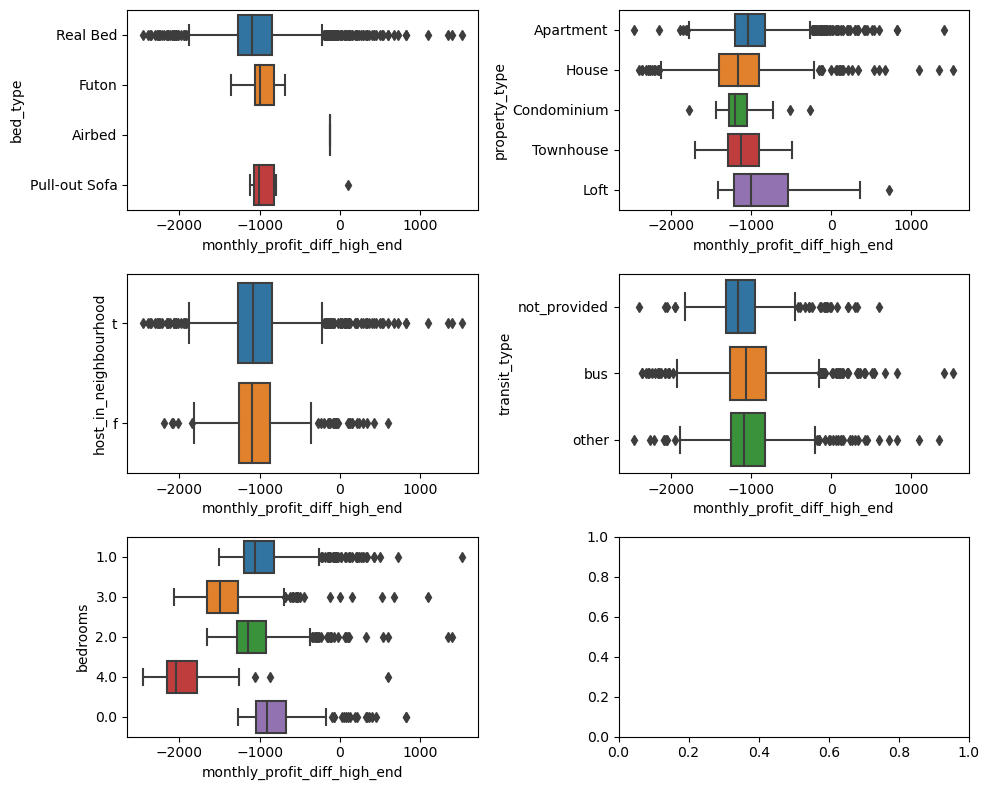

In [81]:
fig, ax = plt.subplots(3,2,figsize=(10,8))
ax = ax.flatten()
for i, col in enumerate(cols_cat):
    sns.boxplot(data = combine,
                x = 'monthly_profit_diff_high_end',
                y = col,
                ax = ax[i])
fig.tight_layout()

<AxesSubplot:xlabel='monthly_profit_diff_high_end', ylabel='zipcode'>

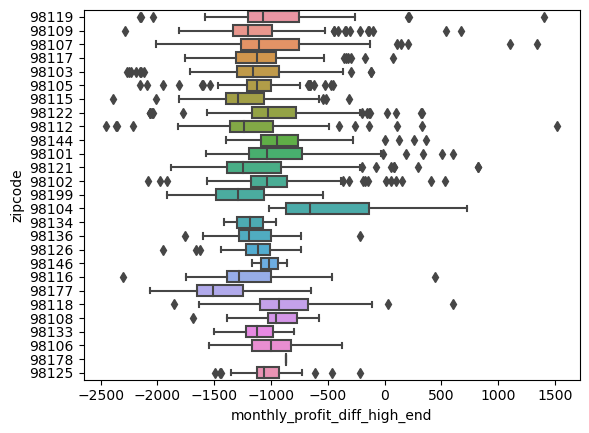

In [82]:
sns.boxplot(data = combine,
            x = 'monthly_profit_diff_high_end',
            y = 'zipcode')

In [83]:
outputs = {}
for col in cols_cat:
    # deal with t f class
    if set(combine[col].unique()) == {'t','f'}:
        cat_ref = 't'
    else:
        cat_ref = combine[col].value_counts().sort_values(ascending=False).index[0]
    dat1 = combine.loc[combine[col] == cat_ref, 'monthly_profit_diff_high_end'].dropna().values
    
    # loop over each unique value
    for cat in combine[col].unique():
        if cat == cat_ref:  continue
        dat2 = combine.loc[combine[col] == cat, 'monthly_profit_diff_high_end'].dropna().values
        
        p = ttest(dat1, dat2, min_count=10)
        print(cat_ref, cat, len(dat1), len(dat2), p)
        if p is np.nan:  continue
        outputs[col+': '+cat_ref+' vs '+cat] = (p, dat1.mean(), dat2.mean(), len(dat1), len(dat2), cat)
        
outputs = pd.DataFrame(data=outputs.values(), index=outputs.keys(), 
                       columns=['p_value','ref_mean','cat_mean','ref_count','cat_count','cat_name'])
outputs['diff'] = outputs['ref_mean'] - outputs['cat_mean']

Real Bed Futon 1963 18 0.5268112019125659
Real Bed Airbed 1963 1 nan
Real Bed Pull-out Sofa 1963 13 0.23439146165130306
Apartment House 1168 712 3.2944537640193357e-19
Apartment Condominium 1168 51 0.0008813449277389418
Apartment Townhouse 1168 37 0.017539133716243306
Apartment Loft 1168 27 0.05500946658047091
t f 1648 347 0.6447310225212186
bus not_provided 1190 402 0.00019145817722778606
bus other 1190 403 0.7924635182870043
1.0 3.0 918 229 1.8033728892858786e-46
1.0 2.0 918 519 1.6272299403250015e-05
1.0 4.0 918 48 1.9844269058289977e-60
1.0 0.0 918 281 3.4246421980638334e-10


In [84]:
outputs.sort_values(by='p_value')

,p_value,ref_mean,cat_mean,ref_count,cat_count,cat_name,diff
bedrooms: 1.0 vs 4.0,1.984427e-60,-960.787020,-1903.289403,918,48,4.0,942.502383
bedrooms: 1.0 vs 3.0,1.803373e-46,-960.787020,-1374.042821,918,229,3.0,413.255802
property_type: Apartment vs House,3.294454e-19,-961.820043,-1141.798595,1168,712,House,179.978553
bedrooms: 1.0 vs 0.0,3.424642e-10,-960.787020,-807.121560,918,281,0.0,-153.665460
bedrooms: 1.0 vs 2.0,1.627230e-05,-960.787020,-1045.857005,918,519,2.0,85.069986
transit_type: bus vs not_provided,1.914582e-04,-1014.825842,-1103.636167,1190,402,not_provided,88.810325
property_type: Apartment vs Condominium,8.813449e-04,-961.820043,-1138.191220,1168,51,Condominium,176.371177
property_type: Apartment vs Townhouse,1.753913e-02,-961.820043,-1110.085545,1168,37,Townhouse,148.265502
property_type: Apartment vs Loft,5.500947e-02,-961.820043,-819.622165,1168,27,Loft,-142.197878
bed_type: Real Bed vs Pull-out Sofa,2.343915e-01,-1033.340248,-892.201917,1963,13,Pull-out Sofa,-141.138331


In [85]:
combine

,id,monthly_profit_diff_high_end,rent,monthly_profit_high_end,bed_type,zipcode,property_type,bedrooms,host_in_neighbourhood,transit_type
0,241032,-476.733333,1247.40,770.666667,Real Bed,98119,Apartment,1.0,t,not_provided
1,953595,-484.285398,1247.40,763.114602,Real Bed,98119,Apartment,1.0,t,bus
2,278830,-678.647164,1663.20,984.552836,Real Bed,98119,House,3.0,t,bus
3,2493658,-805.890430,1247.40,441.509570,Real Bed,98119,Apartment,1.0,t,bus
4,175576,-642.676296,1247.40,604.723704,Real Bed,98119,House,1.0,t,bus
...,...,...,...,...,...,...,...,...,...,...
1993,262764,-1263.003620,1389.15,126.146380,Real Bed,98103,House,2.0,t,bus
1994,8578490,-1280.466667,1297.80,17.333333,Real Bed,98103,Apartment,1.0,t,bus
1995,3383329,-556.841355,1297.80,740.958645,Real Bed,98107,Apartment,1.0,t,bus
1996,8101950,-1688.833333,1738.80,49.966667,Real Bed,98107,House,3.0,f,not_provided


<AxesSubplot:xlabel='bedrooms', ylabel='property_type'>

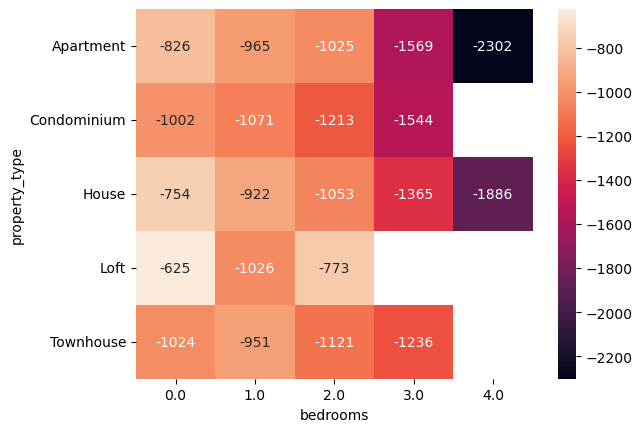

In [86]:
sns.heatmap(combine.pivot_table(values='monthly_profit_diff_high_end',
                                aggfunc='mean',
                                index='property_type',
                                columns='bedrooms'),
            annot = True, fmt='.0f')

<AxesSubplot:xlabel='bedrooms', ylabel='property_type'>

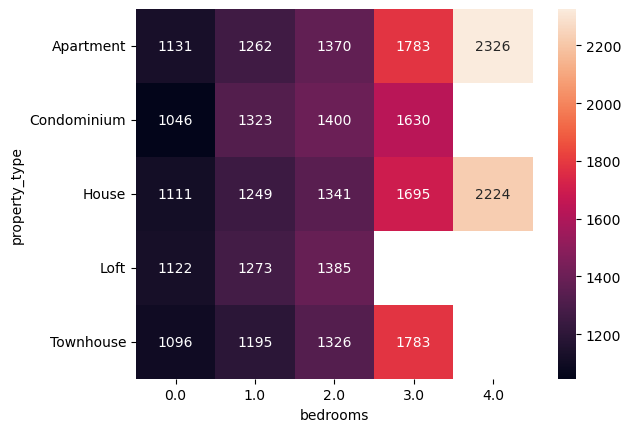

In [87]:
sns.heatmap(combine.pivot_table(values='rent',
                                aggfunc='mean',
                                index='property_type',
                                columns='bedrooms'),
            annot = True, fmt='.0f')

<AxesSubplot:xlabel='bedrooms', ylabel='property_type'>

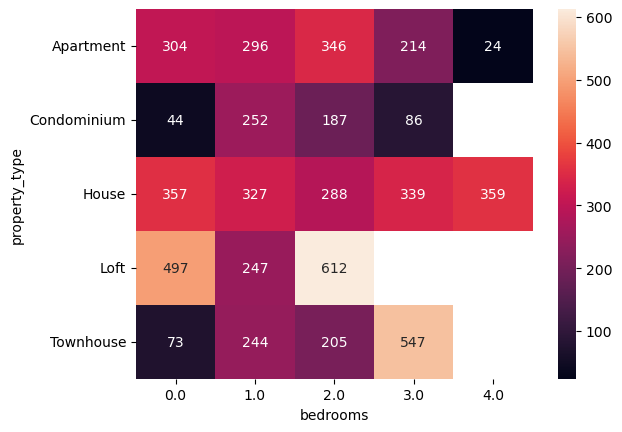

In [88]:
sns.heatmap(combine.pivot_table(values='monthly_profit_high_end',
                                aggfunc='mean',
                                index='property_type',
                                columns='bedrooms'),
            annot = True, fmt='.0f')

### for apartment, condominum and house,  the profit looks the same, the difference is more likely from rent; for loft and townhouse, maybe more rooms brings higher profit, but not enough to offset rent